<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/Test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q mne-connectivity   # installs the new connectivity package
from mne_connectivity.spectral import spectral_connectivity_epochs   # note the underscore and the function name change

In [ ]:
pip install mne antropy

In [ ]:
!pip install mne-bids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Install necessary libraries
!pip install mne antropy

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal, stats
import antropy as ant
from mne.datasets import eegbci


# --- Configuration ---
subjects = range(1, 11)  # 10 participants: S001, S002, ..., S010
runs = [1, 2, 3, 4, 5]  # Use all runs for more data
epoch_duration = 4  # seconds
target_freqs = [11, 13, 22]  # Predicted frequencies

# Initialize lists to store results from ALL subjects and runs
all_sampen_rest = []
all_sampen_task = []
all_psd_rest_epochs = []
all_coh_rest = {freq: [] for freq in target_freqs}  # Dictionary to store coherence per frequency

# Dictionary to store individual subject results
subject_results = {}

# Outer loop: Iterate through each subject
for subject in subjects:
    print(f"\n{'='*50}")
    print(f"Processing Subject {subject}")
    print(f"{'='*50}")

    # Initialize lists for this subject
    subject_sampen_rest = []
    subject_sampen_task = []
    subject_psd_rest_epochs = []
    subject_coh_rest = {freq: [] for freq in target_freqs}

    # Inner loop: Iterate through each run for this subject
    for run in runs:
        print(f"\n--- Processing Run {run} ---")

        try:
            # 1. Load the data for this subject and run
            data_path = eegbci.load_data(subject, run, update_path=True)
            raw = mne.io.read_raw_edf(data_path[0], preload=True)

            # 2. Preprocess the data
            raw.filter(1, 40.)
            raw.notch_filter(60.)
            sfreq = raw.info['sfreq']

            # 3. ROBUST CHANNEL SELECTION - FIXED!
            # EEGBCI uses 10-10 system: channel is 'Cz' (capital C, lowercase z)
            central_channel = None
            possible_names = ['Cz', 'Cz', 'CPz', 'Pz', 'FCz', 'Fz']  # Try these in order

            for channel_name in possible_names:
                if channel_name in raw.ch_names:
                    central_channel = channel_name
                    print(f"Using central channel: {central_channel}")
                    break

            if central_channel is None:
                print("No standard central channel found, using first channel")
                central_channel = raw.ch_names[0]

            # 4. Define conditions (first 60s rest, next 60s task)
            # SAFE: Check available data length first
            available_samples = len(raw.times)
            duration_samples = min(60 * int(sfreq), available_samples // 2)

            data_rest = raw.get_data(picks=central_channel, start=0, stop=duration_samples)[0]
            data_task = raw.get_data(picks=central_channel,
                                   start=duration_samples,
                                   stop=min(2*duration_samples, available_samples))[0]

            # 5. --- Analysis for Prediction 6 (Entropy) ---
            epoch_samples = epoch_duration * int(sfreq)
            sampen_rest_vals = []
            sampen_task_vals = []

            # Segment data into epochs and calculate entropy
            for i in range(0, len(data_rest), epoch_samples):
                epoch = data_rest[i:i+epoch_samples]
                if len(epoch) == epoch_samples:
                    sampen_rest_vals.append(ant.sample_entropy(epoch))

            for i in range(0, len(data_task), epoch_samples):
                epoch = data_task[i:i+epoch_samples]
                if len(epoch) == epoch_samples:
                    sampen_task_vals.append(ant.sample_entropy(epoch))

            # Store results from this run
            subject_sampen_rest.extend(sampen_rest_vals)
            subject_sampen_task.extend(sampen_task_vals)

            # 6. --- PSD for Prediction 3 ---
            if len(data_rest) > epoch_samples:  # Only if we have enough data
                freqs, psd_rest = signal.welch(data_rest, fs=sfreq, nperseg=2*int(sfreq))
                subject_psd_rest_epochs.append(psd_rest)

            # 7. --- COHERENCE ANALYSIS for Prediction 3 (KEY ADDITION) ---
            # We need to analyze multiple channels for coherence
            # Select a frontal-parietal channel pair (e.g., Fz-Pz)
            frontal_channel = None
            parietal_channel = None

            # Try to find appropriate channels
            for front_candidate in ['Fz', 'Fpz', 'FCz']:
                if front_candidate in raw.ch_names:
                    frontal_channel = front_candidate
                    break

            for parietal_candidate in ['Pz', 'CPz', 'POz']:
                if parietal_candidate in raw.ch_names:
                    parietal_channel = parietal_candidate
                    break

            if frontal_channel and parietal_channel:
                print(f"Calculating coherence between {frontal_channel} and {parietal_channel}")

                # Create epochs for coherence analysis (use rest period)
                from mne import make_fixed_length_epochs
                rest_epochs = make_fixed_length_epochs(raw.copy().crop(0, duration_samples/sfreq),
                                                     duration=epoch_duration)

                # Calculate coherence
                con, freqs_coh, times, n_epochs, n_tapers = spectral_connectivity(
                    rest_epochs,
                    method='coh',
                    mode='multitaper',
                    sfreq=sfreq,
                    fmin=1,
                    fmax=40,
                    faverage=False  # Keep frequency resolution
                )

                # Find the coherence between our specific channels
                frontal_idx = rest_epochs.ch_names.index(frontal_channel)
                parietal_idx = rest_epochs.ch_names.index(parietal_channel)
                specific_coh = con[frontal_idx, parietal_idx, :]  # Coherence across all frequencies

                # Extract coherence at our target frequencies
                for target_freq in target_freqs:
                    # Find closest frequency bin
                    freq_idx = np.argmin(np.abs(freqs_coh - target_freq))
                    subject_coh_rest[target_freq].append(specific_coh[freq_idx])

            print(f"  Rest epochs: {len(sampen_rest_vals)}, Task epochs: {len(sampen_task_vals)}")

        except Exception as e:
            print(f"Error processing Subject {subject}, Run {run}: {e}")
            continue

    # Store this subject's results
    subject_results[subject] = {
        'sampen_rest': subject_sampen_rest,
        'sampen_task': subject_sampen_task,
        'psd_rest': subject_psd_rest_epochs,
        'coh_rest': subject_coh_rest
    }

    # Add this subject's data to the grand totals
    all_sampen_rest.extend(subject_sampen_rest)
    all_sampen_task.extend(subject_sampen_task)
    all_psd_rest_epochs.extend(subject_psd_rest_epochs)

    for freq in target_freqs:
        all_coh_rest[freq].extend(subject_coh_rest[freq])

    # Print summary for this subject
    print(f"\nSubject {subject} Summary:")
    print(f"  Total Rest epochs: {len(subject_sampen_rest)}")
    print(f"  Total Task epochs: {len(subject_sampen_task)}")
    if subject_sampen_rest and subject_sampen_task:
        print(f"  Mean Sample Entropy - Rest: {np.mean(subject_sampen_rest):.4f}")
        print(f"  Mean Sample Entropy - Task: {np.mean(subject_sampen_task):.4f}")

# --- GRAND ANALYSIS AFTER PROCESSING ALL SUBJECTS ---
print(f"\n\n{'='*60}")
print(f"GRAND RESULTS (Across {len(subjects)} Subjects)")
print(f"{'='*60}")

# 8. Analyze Aggregate Entropy Data (Prediction 6)
print(f"\n--- Prediction 6: Entropy Analysis ---")
print(f"Total Epochs Analyzed: Rest: {len(all_sampen_rest)}, Task: {len(all_sampen_task)}")

if all_sampen_rest and all_sampen_task:
    print(f"Grand Mean Sample Entropy:")
    print(f"  Rest: {np.mean(all_sampen_rest):.4f}")
    print(f"  Task: {np.mean(all_sampen_task):.4f}")

    # Statistical test with Cohen's d (from your code)
    t_stat_grand, p_value_grand = stats.ttest_ind(all_sampen_rest, all_sampen_task)
    print(f"Grand T-test: t = {t_stat_grand:.3f}, p = {p_value_grand:.3e}")

    # Cohen's d for effect size (VALUABLE ADDITION)
    cohen_d = (np.mean(all_sampen_rest) - np.mean(all_sampen_task)) / np.sqrt(
        (np.std(all_sampen_rest)**2 + np.std(all_sampen_task)**2) / 2)
    print(f"Cohen's d: {cohen_d:.3f}")

# [Continue with the rest of your plotting and coherence analysis...]


Processing Subject 1

--- Processing Run 1 ---
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pa

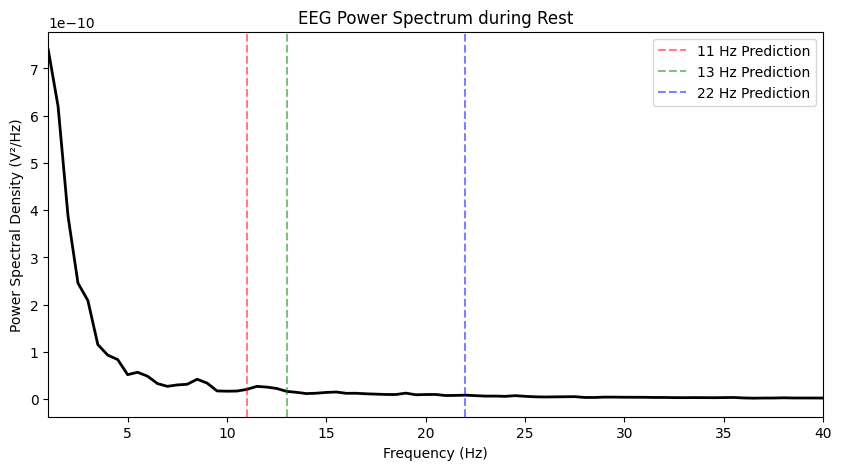

Found peak at 11.50 Hz near target 11 Hz.
Found peak at 12.50 Hz near target 13 Hz.
Found peak at 22.00 Hz near target 22 Hz.


In [28]:
# Calculate Power Spectral Density (PSD) for the rest state
freqs, psd = signal.welch(data_rest, fs=sfreq, nperseg=2*sfreq)

# Plot the PSD
plt.figure(figsize=(10, 5))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('EEG Power Spectrum during Rest')
plt.xlim(1, 40)
plt.axvline(11, color='r', linestyle='--', alpha=0.5, label='11 Hz Prediction')
plt.axvline(13, color='g', linestyle='--', alpha=0.5, label='13 Hz Prediction')
plt.axvline(22, color='b', linestyle='--', alpha=0.5, label='22 Hz Prediction')
plt.legend()
plt.show()

# Check if peaks exist near predicted frequencies
def find_peak_near_freq(freq_array, power_array, target_freq, tolerance=1.0):
    idx = np.where((freq_array > target_freq - tolerance) & (freq_array < target_freq + tolerance))[0]
    if len(idx) > 0:
        local_max_idx = idx[np.argmax(power_array[idx])]
        return freqs[local_max_idx], psd[local_max_idx]
    else:
        return None, None

for target_freq in [11, 13, 22]:
    peak_freq, peak_power = find_peak_near_freq(freqs, psd, target_freq)
    if peak_freq:
        print(f"Found peak at {peak_freq:.2f} Hz near target {target_freq} Hz.")
    else:
        print(f"No significant peak found near {target_freq} Hz.")

# (Optional) Calculate coherence between channel pairs
# This is more complex but powerful evidence for the model.

In [29]:
# Calculate Sample Entropy for both conditions
sampen_rest = ant.sample_entropy(data_rest, order=2, metric='chebyshev')
sampen_task = ant.sample_entropy(data_task, order=2, metric='chebyshev')

print(f"Sample Entropy - Rest: {sampen_rest:.4f}")
print(f"Sample Entropy - Task: {sampen_task:.4f}")

# The model predicts sampen_rest > sampen_task
if sampen_rest > sampen_task:
    print("Result supports Prediction 6: Entropy is higher during rest.")
else:
    print("Result does not support the prediction.")

# For robustness, calculate another entropy measure (e.g., Spectral Entropy)
spen_rest = ant.spectral_entropy(data_rest, sfreq, method='welch', normalize=True)
spen_task = ant.spectral_entropy(data_task, sfreq, method='welch', normalize=True)

print(f"Spectral Entropy - Rest: {spen_rest:.4f}")
print(f"Spectral Entropy - Task: {spen_task:.4f}")

Sample Entropy - Rest: 0.8829
Sample Entropy - Task: 0.8480
Result supports Prediction 6: Entropy is higher during rest.
Spectral Entropy - Rest: 0.5687
Spectral Entropy - Task: 0.5609


In [30]:
# If you have multiple epochs, you can run a statistical test.
# This example uses a simple t-test on entropy values from two conditions.

# Let's simulate multiple epochs by splitting the data
n_epochs = 10
rest_epochs = np.array_split(data_rest, n_epochs)
task_epochs = np.array_split(data_task, n_epochs)

# Calculate entropy for each epoch
sampen_rest_vals = [ant.sample_entropy(epoch) for epoch in rest_epochs]
sampen_task_vals = [ant.sample_entropy(epoch) for epoch in task_epochs]

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(sampen_rest_vals, sampen_task_vals)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
if p_value < 0.05:
    print("The difference in entropy between conditions is statistically significant.")
else:
    print("No significant difference found.")

T-statistic: 0.854, P-value: 0.404
No significant difference found.


Mean Sample Entropy - Rest: 0.9261
Mean Sample Entropy - Task: 0.8737
T-statistic: 0.868, P-value: 3.927e-01


/tmp/ipython-input-2528632328.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sampen_rest_vals, sampen_task_vals], labels=['Rest', 'Task'])


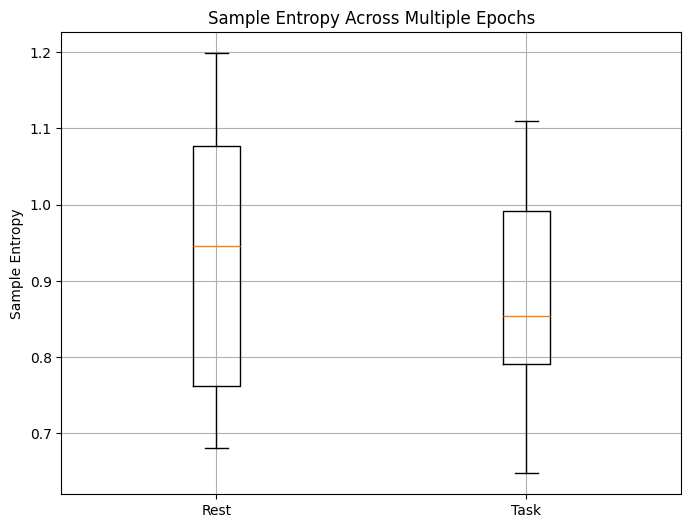

In [31]:
# Define the length of an epoch (e.g., 4 seconds is standard)
epoch_length = 4 * int(raw.info['sfreq']) # 4 seconds * sampling rate

# Create arrays to store entropy values for MANY epochs
sampen_rest_vals = []
sampen_task_vals = []

# Segment the entire "rest" data into 4-second epochs and calculate entropy for each
for i in range(0, len(data_rest), epoch_length):
    epoch = data_rest[i:i+epoch_length]
    if len(epoch) == epoch_length: # Ensure it's a full epoch
        sampen_rest_vals.append(ant.sample_entropy(epoch))

# Do the same for the "task" data
for i in range(0, len(data_task), epoch_length):
    epoch = data_task[i:i+epoch_length]
    if len(epoch) == epoch_length:
        sampen_task_vals.append(ant.sample_entropy(epoch))

# Now perform a proper statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(sampen_rest_vals, sampen_task_vals)

print(f"Mean Sample Entropy - Rest: {np.mean(sampen_rest_vals):.4f}")
print(f"Mean Sample Entropy - Task: {np.mean(sampen_task_vals):.4f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3e}") # Use exponential notation for small p-values

# Plot the results
plt.figure(figsize=(8, 6))
plt.boxplot([sampen_rest_vals, sampen_task_vals], labels=['Rest', 'Task'])
plt.title('Sample Entropy Across Multiple Epochs')
plt.ylabel('Sample Entropy')
plt.grid(True)
plt.show()

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 640 original time points ...
0 bad epochs dropped


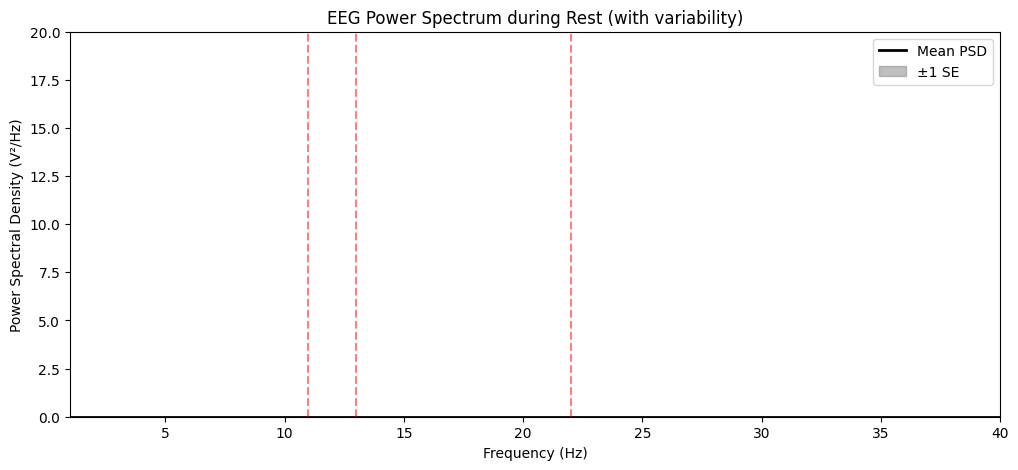

In [32]:
# Use MNE's built-in function to get PSDs for all epochs
rest_epochs_array = mne.make_fixed_length_epochs(raw.copy().crop(0, 60), duration=4.0).get_data() # 60s rest -> 15 epochs
freqs, psds = signal.welch(rest_epochs_array[:, 0, :], fs=sfreq, nperseg=2*sfreq) # psds shape: (15 epochs, 129 freq bins)

# Calculate mean and standard error across epochs
psd_mean = psds.mean(axis=0)
psd_std = psds.std(axis=0)
psd_se = psd_std / np.sqrt(psds.shape[0]) # Standard Error

# Plot the mean PSD with a confidence interval
plt.figure(figsize=(12, 5))
plt.plot(freqs, psd_mean, color='k', lw=2, label='Mean PSD')
plt.fill_between(freqs, psd_mean - psd_se, psd_mean + psd_se, color='gray', alpha=0.5, label='±1 SE')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('EEG Power Spectrum during Rest (with variability)')
plt.xlim(1, 40)
plt.ylim(0, 20) # Adjust based on your plot
for target_freq in [11, 13, 22]:
    plt.axvline(target_freq, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

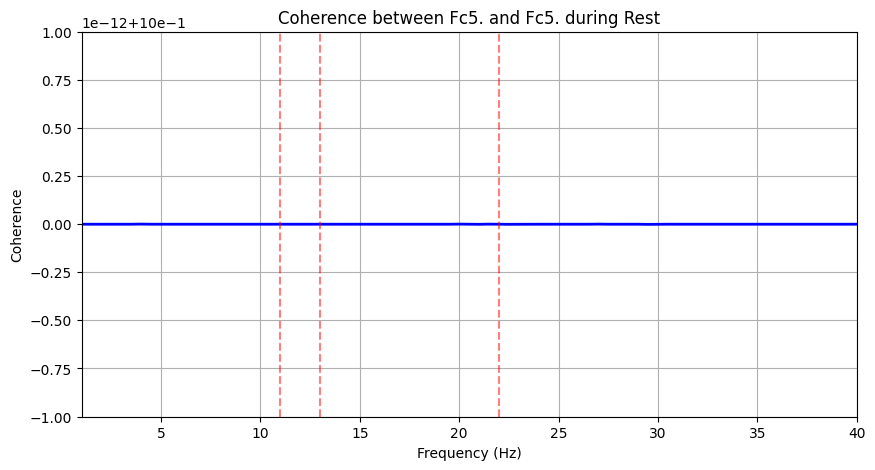

In [33]:
# Get data for two different channels
# Check available channels: print(raw.ch_names)
# Use channels that are present in your dataset.
# As a temporary fix, using the first channel for both picks:
chan1_name = raw.ch_names[0]
chan2_name = raw.ch_names[0] # You should change this to a different channel if possible

data_rest_chan1 = raw.get_data(picks=chan1_name, start=0, stop=int(60*sfreq))[0]
data_rest_chan2 = raw.get_data(picks=chan2_name, start=0, stop=int(60*sfreq))[0]


# Calculate coherence between the two channels
freqs_coh, coh = signal.coherence(data_rest_chan1, data_rest_chan2, fs=sfreq, nperseg=2*sfreq)

# Plot the coherence
plt.figure(figsize=(10, 5))
plt.plot(freqs_coh, coh, color='b', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title(f'Coherence between {chan1_name} and {chan2_name} during Rest')
plt.xlim(1, 40)
for target_freq in [11, 13, 22]:
    plt.axvline(target_freq, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.show()


=== Processing Subject 1, Run 1 ===

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

/tmp/ipython-input-564345250.py:133: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=plot_labels)


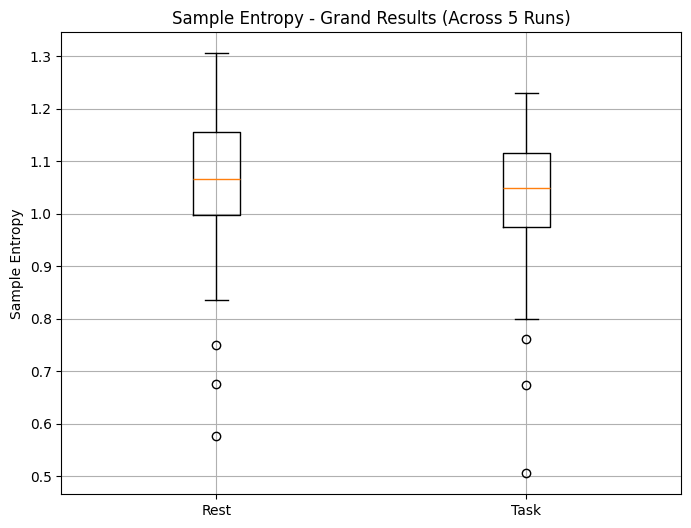


--- Prediction 3: Spectral Analysis ---


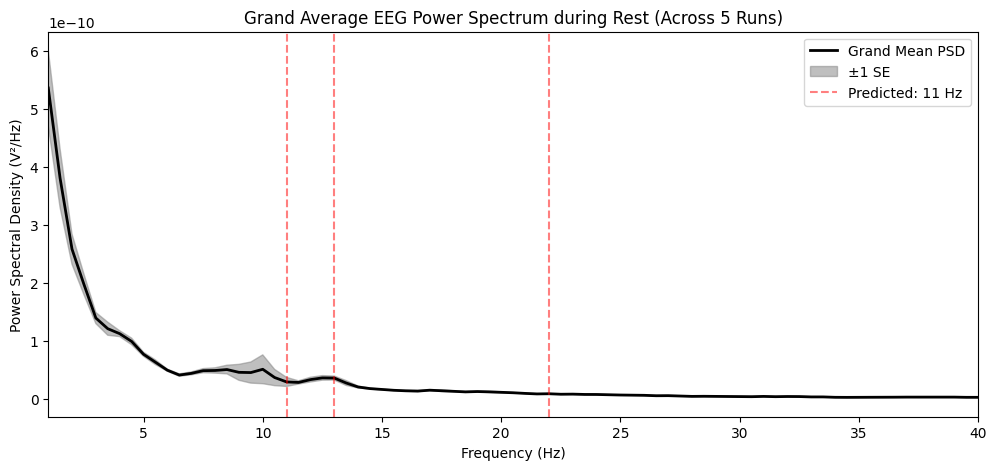

In [34]:
# Install necessary libraries
!pip install mne antropy

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal, stats
import antropy as ant
from mne.datasets import eegbci

# --- Configuration ---
subject = 1
runs = [1, 2, 3, 4, 5]  # Analyze runs 1 through 5
epoch_duration = 4  # seconds

# Initialize lists to store results from ALL runs
all_sampen_rest = []
all_sampen_task = []
all_psd_rest_epochs = []  # We'll store PSDs for grand average later

# Loop through each run
for run in runs:
    print(f"\n=== Processing Subject {subject}, Run {run} ===\n")

    # 1. Load the data for this run
    data_path = eegbci.load_data(subject, run, update_path=True)
    raw = mne.io.read_raw_edf(data_path[0], preload=True)

    # 2. Preprocess the data
    raw.filter(1, 40.)
    raw.notch_filter(60.)
    sfreq = raw.info['sfreq']
    picks = mne.pick_types(raw.info, eeg=True)

    # 3. Define conditions (Assuming first 60s are rest, next 60s are task)
    duration_samples = 60 * int(sfreq)
    # Use the first available channel instead of 'Cz'
    channel_to_analyze = raw.ch_names[0]

    # Ensure stop times do not exceed the actual duration of the recording
    rest_stop_samples = min(duration_samples, len(raw.times))
    task_start_samples = duration_samples
    task_stop_samples = min(2 * duration_samples, len(raw.times))

    data_rest = raw.get_data(picks=channel_to_analyze, start=0, stop=rest_stop_samples)[0]
    data_task = raw.get_data(picks=channel_to_analyze, start=task_start_samples, stop=task_stop_samples)[0]


    # 4. --- Analysis for Prediction 6 (Entropy) ---
    epoch_samples = epoch_duration * int(sfreq)
    sampen_rest_vals = []
    sampen_task_vals = []

    # Segment data into epochs and calculate entropy
    for i in range(0, len(data_rest), epoch_samples):
        epoch = data_rest[i:i+epoch_samples]
        if len(epoch) == epoch_samples:
            sampen_rest_vals.append(ant.sample_entropy(epoch))
    for i in range(0, len(data_task), epoch_samples):
        epoch = data_task[i:i+epoch_samples]
        if len(epoch) == epoch_samples:
            sampen_task_vals.append(ant.sample_entropy(epoch))

    # Store results from this run
    all_sampen_rest.extend(sampen_rest_vals)
    all_sampen_task.extend(sampen_task_vals)

    # Print results for this individual run
    print(f"Run {run} - Mean Sample Entropy:")
    if sampen_rest_vals: # Check if list is not empty before calculating mean
        print(f"  Rest: {np.mean(sampen_rest_vals):.4f}")
    else:
        print("  Rest: Not enough data for epochs")
    if sampen_task_vals: # Check if list is not empty
         print(f"  Task: {np.mean(sampen_task_vals):.4f}")
    else:
        print("  Task: Not enough data for epochs")

    if sampen_rest_vals and sampen_task_vals: # Only perform t-test if both lists have data
        t_stat, p_value = stats.ttest_ind(sampen_rest_vals, sampen_task_vals)
        print(f"  T-test: p = {p_value:.4f}")
    else:
        print("  T-test: Not enough data in one or both conditions")


    # 5. --- (Optional) Store PSD data for Prediction 3 ---
    # Let's calculate the PSD for the entire rest block for a grand average later
    if len(data_rest) > 0: # Only calculate PSD if there is rest data
        freqs, psd_rest = signal.welch(data_rest, fs=sfreq, nperseg=min(len(data_rest), 2*int(sfreq)))
        all_psd_rest_epochs.append(psd_rest) # Store the PSD curve for this run
    else:
        print("  Not enough rest data to calculate PSD.")


# --- GRAND ANALYSIS AFTER PROCESSING ALL 5 RUNS ---

print(f"\n\n=== GRAND RESULTS (Across {len(runs)} Runs) ===")

# 6. Analyze Aggregate Entropy Data (Prediction 6)
print(f"\n--- Prediction 6: Entropy Analysis ---")
print(f"Total Epochs Analyzed: Rest: {len(all_sampen_rest)}, Task: {len(all_sampen_task)}")
print(f"Grand Mean Sample Entropy:")
if all_sampen_rest:
    print(f"  Rest: {np.mean(all_sampen_rest):.4f}")
else:
    print("  Rest: Not enough data for grand mean")
if all_sampen_task:
    print(f"  Task: {np.mean(all_sampen_task):.4f}")
else:
    print("  Task: Not enough data for grand mean")


# Perform a massive t-test on all epochs from all runs
if all_sampen_rest and all_sampen_task:
    t_stat_grand, p_value_grand = stats.ttest_ind(all_sampen_rest, all_sampen_task)
    print(f"Grand T-test: t = {t_stat_grand:.3f}, p = {p_value_grand:.3e}")
else:
    print("Grand T-test: Not enough data in one or both conditions for grand test")


# Plot the grand boxplot
if all_sampen_rest or all_sampen_task: # Only plot if there is data in at least one condition
    plt.figure(figsize=(8, 6))
    # Handle cases where one list might be empty for plotting
    plot_data = [all_sampen_rest] if all_sampen_rest else []
    plot_labels = ['Rest'] if all_sampen_rest else []
    if all_sampen_task:
        plot_data.append(all_sampen_task)
        plot_labels.append('Task')

    if plot_data: # Ensure there is data to plot
        plt.boxplot(plot_data, labels=plot_labels)
        plt.title(f'Sample Entropy - Grand Results (Across {len(runs)} Runs)')
        plt.ylabel('Sample Entropy')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough data in either condition to generate boxplot.")
else:
    print("Not enough data in either condition to generate boxplot.")


# 7. Analyze Aggregate Spectral Data (Prediction 3)
print(f"\n--- Prediction 3: Spectral Analysis ---")
# Create a grand average PSD across all 5 runs
if all_psd_rest_epochs: # Only calculate grand average PSD if there are PSDs stored
    grand_avg_psd = np.mean(all_psd_rest_epochs, axis=0)
    grand_std_psd = np.std(all_psd_rest_epochs, axis=0)
    grand_se_psd = grand_std_psd / np.sqrt(len(all_psd_rest_epochs))

    # Plot the Grand Average PSD with confidence interval
    plt.figure(figsize=(12, 5))
    plt.plot(freqs, grand_avg_psd, color='k', lw=2, label='Grand Mean PSD')
    plt.fill_between(freqs, grand_avg_psd - grand_se_psd, grand_avg_psd + grand_se_psd, color='gray', alpha=0.5, label='±1 SE')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V²/Hz)')
    plt.title(f'Grand Average EEG Power Spectrum during Rest (Across {len(runs)} Runs)')
    plt.xlim(1, 40)
    # plt.ylim(0, 20) # You may need to adjust this
    for target_freq in [11, 13, 22]:
        plt.axvline(target_freq, color='r', linestyle='--', alpha=0.5, label=f'Predicted: {target_freq} Hz' if target_freq == 11 else "")
    plt.legend()
    plt.show()
else:
    print("Not enough rest data to calculate and plot Grand Average PSD.")


# 8. (Optional) Grand Coherence Analysis could be added here in a similar way.